**Adding Noise for Robust Deep Neural Network Models**
---
* In this notebook, We will explore how to add noise in the image.
* Train a model with noise based images.
* Noise Types: Guassian, Salt and Papper and Speckle Noise
* **Dataset** : CIFAR10

**1.Load Modules**
---

In [1]:
# torch loaded..!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(42)

# torchvision loaded..!!!
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchsummary import summary

# other module loaded..!!!
import numpy as np
import matplotlib.pyplot as plt
import time
import os
plt.style.use('ggplot')

Going over all the important imports:

* `torch`: as we will be implementing everything using the PyTorch deep learning library, so we import torch first.
* `torchvision`: this module will help us download the CIFAR10 dataset, pre-trained PyTorch models, and also define the transforms that we will apply to the images.
* `torch.nn`: we will get access to all the neural network layers through torch.nn.
* `torch.optim`: this will help us define the optimizer of our choice.
* `argparse`: for defining our argument parsers.
* `matplotlib`: for saving the plots after training and validation.

**2.Define the Constants**
---

In [42]:
EPOCHS = 10
TRAIN_NOISE = True
TEST_NOISE = False
BATCH_SIZE = 32
NUM_CLASSES = 10
pretrained=True
requires_grad=True

**3.Defining Transform and Helper Function**
---

In [21]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**4.Preparing Data**
---

In [23]:
# Data Downloading
trainset = datasets.CIFAR10(root='./data_cifar10/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform)

# Data Loader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**5.Prepare the Neural Network**
---

In [43]:
def model():
    model = models.resnet18(progress=True, pretrained=pretrained)
    # freeze hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layers learnable
    model.fc = nn.Linear(512, NUM_CLASSES)
    
    model = model.to(device)
    
    return model
model = model()

In [52]:
print(summary(model, (3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]            --
|

**6. Define The Loss Function**
---

In [45]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.99)

**7.The Training Function**
---

In [46]:
# The training function
from tqdm import tqdm
print(f'Training with Noise:{TRAIN_NOISE}')
print(f'Testing with Noise:{TEST_NOISE}')
print(f'Pretrained: {pretrained}, Required Gradient: {requires_grad}')

if pretrained and requires_grad:
    print('Training with ImageNet Weights and updating hidden layer weights')
elif pretrained and not requires_grad:
    print('Training with ImageNet Weights but Freezing hidden layer weights')
elif not pretrained and requires_grad:
    print('Training with random weights and updating hidden layer weights')
elif not pretrained and not requires_grad:
    print('Training with random weights but Freezing hidden layer weights')

def train(NUM_EPOCHs, epoch, model, dataloader):
    model.train()
    loss = 0
    acc = 0
    running_loss = 0
    running_correct = 0
    with tqdm(trainLoader, unit="batch") as tepoch:
        for i,data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}")
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            if TRAIN_NOISE:
                noise = torch.randn(inputs.shape).to(device)
                new_img = inputs + noise
            elif TRAIN_NOISE == False:
                new_img = inputs
                
            new_img = new_img.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(new_img)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            
            running_loss += loss.item()
            running_correct += torch.sum(preds == labels.data).sum().item()
            
            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
            # print statistics
            tepoch.set_postfix(loss=running_loss/(i+1), acc= 100. * running_correct / (BATCH_SIZE * (i+1)))
            
    loss = running_loss / len(trainLoader)
    acc = 100. * running_correct / len(trainLoader.dataset)
    print(f'Epoch {epoch+1} Loss: {loss:.4f} Acc: {acc:.4f}')
    return loss, acc

Training with Noise:True
Testing with Noise:False
Pretrained: True, Required Gradient: True
Training with ImageNet Weights and updating hidden layer weights


**8.The valildation Function**
---

In [47]:
# the validation function
def validate(NUM_EPOCHS, epoch, model, testloader):
    model.eval()
    loss = 0.0
    acc = 0
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            img, labels = data[0].to(device), data[1].to(device)
            # add noise to the image data
            if TEST_NOISE:
                noise = torch.randn(img.shape).to(device)
                new_img = img + noise
            elif TEST_NOISE == False:
                new_img = img
            new_img = new_img.to(device)
            outputs = model(new_img)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            running_loss += loss.item()
            running_correct += (preds == labels).sum().item()
    loss = running_loss / len(testset)
    acc = 100. * running_correct / len(testset)
    print(f"Epoch {epoch+1} of {NUM_EPOCHS}, val loss: {loss:.3f}, val acc: {acc:.3f}")
    return loss, acc 

In [48]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []
start = time.time()
for epoch in range(EPOCHS):
    e_start = time.time()
    train_epoch_loss, train_epoch_acc = train(EPOCHS, epoch, model, trainLoader)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_epoch_loss, val_epoch_acc = validate(EPOCHS, epoch, model, testLoader)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)
    e_end = time.time()
    print(f"Took {(e_end-e_start)/60:.3f} minutes for epoch {epoch+1}")
end = time.time()
print(f"Took {(end-start)/60:.3f} minutes to train")

Epoch 1: 100%|██████████| 1563/1563 [01:07<00:00, 23.20batch/s, acc=32, loss=1.99]


Epoch 1 Loss: 1.9949 Acc: 32.0180
Epoch 1 of 10, val loss: 0.073, val acc: 30.370
Took 1.207 minutes for epoch 1


Epoch 2: 100%|██████████| 1563/1563 [01:07<00:00, 23.16batch/s, acc=39.9, loss=1.71]


Epoch 2 Loss: 1.7139 Acc: 39.8840
Epoch 2 of 10, val loss: 0.097, val acc: 26.600
Took 1.207 minutes for epoch 2


Epoch 3: 100%|██████████| 1563/1563 [01:08<00:00, 22.83batch/s, acc=44, loss=1.58]


Epoch 3 Loss: 1.5783 Acc: 43.9740
Epoch 3 of 10, val loss: 0.105, val acc: 26.970
Took 1.224 minutes for epoch 3


Epoch 4: 100%|██████████| 1563/1563 [01:07<00:00, 23.26batch/s, acc=47.1, loss=1.48]


Epoch 4 Loss: 1.4815 Acc: 47.1320
Epoch 4 of 10, val loss: 0.074, val acc: 32.890
Took 1.201 minutes for epoch 4


Epoch 5: 100%|██████████| 1563/1563 [01:07<00:00, 23.09batch/s, acc=49.3, loss=1.43]


Epoch 5 Loss: 1.4307 Acc: 49.2880
Epoch 5 of 10, val loss: 0.124, val acc: 24.470
Took 1.210 minutes for epoch 5


Epoch 6: 100%|██████████| 1563/1563 [01:08<00:00, 22.66batch/s, acc=52.2, loss=1.35]


Epoch 6 Loss: 1.3495 Acc: 52.1680
Epoch 6 of 10, val loss: 0.074, val acc: 33.030
Took 1.226 minutes for epoch 6


Epoch 7: 100%|██████████| 1563/1563 [01:00<00:00, 25.72batch/s, acc=53.9, loss=1.3]


Epoch 7 Loss: 1.2987 Acc: 53.9180
Epoch 7 of 10, val loss: 0.077, val acc: 31.160
Took 1.100 minutes for epoch 7


Epoch 8: 100%|██████████| 1563/1563 [01:03<00:00, 24.66batch/s, acc=54.6, loss=1.28]


Epoch 8 Loss: 1.2794 Acc: 54.5740
Epoch 8 of 10, val loss: 0.065, val acc: 35.730
Took 1.133 minutes for epoch 8


Epoch 9: 100%|██████████| 1563/1563 [01:17<00:00, 20.22batch/s, acc=56.3, loss=1.23]


Epoch 9 Loss: 1.2277 Acc: 56.3420
Epoch 9 of 10, val loss: 0.082, val acc: 33.280
Took 1.370 minutes for epoch 9


Epoch 10: 100%|██████████| 1563/1563 [01:16<00:00, 20.46batch/s, acc=56.9, loss=1.22]


Epoch 10 Loss: 1.2160 Acc: 56.8800
Epoch 10 of 10, val loss: 0.064, val acc: 38.480
Took 1.350 minutes for epoch 10
Took 12.226 minutes to train


**9.Model Evaluation**
---

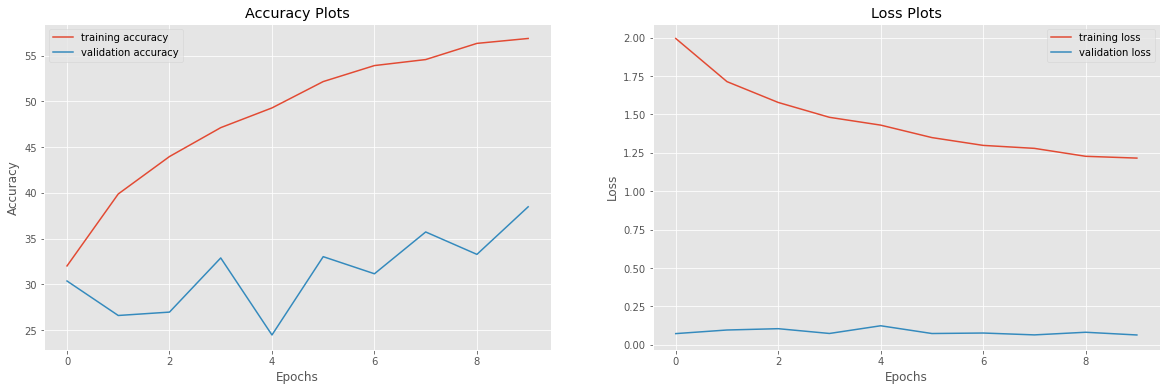

In [51]:
torch.save(model, f"{TRAIN_NOISE}_{TEST_NOISE}.pth")
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(train_acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy Plots')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig(f"outputs/plots/{TRAIN_NOISE}_{TEST_NOISE}_acc.png")
plt.subplot(122)
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss Plots')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(f"outputs/plots/{args['train_noise']}_{args['test_noise']}_loss.png")
plt.show()